In [0]:
import torch
import torch.nn
import torch.optim
import torchvision.datasets
import torchvision.transforms
import torch.utils.data

In [0]:
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
BATCH_SIZE = 32
EPOCHS = 10

# TODO

* Use `model.train()` `model.eval()` appropriately
* Training and validation loss curves
* Early stopping at minimum validation loss
* Plot with loss curves for autoencoder with different bottleneck sizes
* Maybe regularization methods at transfer-learning step

# Exercise 1: Convolutional Autoencoder

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
Generate 5 new images by injecting random values as input to the decoder. Show them.


## Module definition

Our autoencoder will be defined by the `ConvolutionalAutoencoder` class which uses a `ConvolutionalEncoder` object to encode followed a `ConvolutionalDecoder` object to decode. The `ConvolutionalEncoder` and `ConvolutionalDecoder` classes make use of `n_blocks` `ConvolutionalBlock`s or `DeconvolutionalBlock`s which are composed of `layer_per_block` convolution layers with the same number of filters.

The dimensionality is reduced by applying 2-factor spatial downsampling at each block. The number of filters is doubled for each subsequent block. The decoder makes the exact oposite process.

The final layer uses a tanh activation.

In [0]:
# %load models.py
import torch
import torch.nn


class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, n_blocks, downsampling_method, upsampling_method, layers_per_block=2):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method

        self.encoder = ConvolutionalEncoder(n_blocks, downsampling_method, layers_per_block=layers_per_block)
        self.decoder = ConvolutionalDecoder(n_blocks, upsampling_method, self.encoder.output_channels,
                                            layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction


class ConvolutionalAutoencoderReducedLatentDim(torch.nn.Module):

    def __init__(self, input_shape, n_blocks, downsampling_method, upsampling_method, layers_per_block=2,
                 latent_dimensionality=50):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method
        self.latent_dimensionality = latent_dimensionality

        # Encoder: Convolutional blocks + Linear
        self.convolutional_encoder = ConvolutionalEncoder(
            n_blocks, downsampling_method, layers_per_block=layers_per_block)
        self.output_shape = (self.convolutional_encoder.init_filters * 2 ** (n_blocks - 1),
                             input_shape[0] // 2 ** n_blocks,
                             input_shape[1] // 2 ** n_blocks)
        self.encoder = torch.nn.Sequential(
            self.convolutional_encoder,
            torch.nn.Flatten(),
            torch.nn.Linear(self.output_shape[0] * self.output_shape[1] * self.output_shape[2],
                            latent_dimensionality),
            torch.nn.ReLU()
        )


        # Decoder: Linear + Convolutional blocks
        self.linear_decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dimensionality, self.output_shape[0] * self.output_shape[1] * self.output_shape[2]),
            torch.nn.ReLU()
        )
        self.convolutional_decoder = ConvolutionalDecoder(n_blocks, upsampling_method,
                                                          self.convolutional_encoder.output_channels,
                                                          layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.convolutional_decoder(self.linear_decoder(code).view((-1,) + self.output_shape))
        return reconstruction


class ConvolutionalEncoder(torch.nn.Module):
    DOWNSAMPLING_METHODS = ["max-pooling", "avg-pooling", "stride-2"]

    def __init__(self, n_blocks, downsampling_method, init_filters=16, layers_per_block=2, kernel_size=5,
                 input_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert downsampling_method in self.DOWNSAMPLING_METHODS
        self.downsampling_method = downsampling_method
        self.layers_per_block = layers_per_block
        self.init_filters = init_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels

        # First layer so we have <input_channels> channels.
        n_filters = init_filters
        layers = [ConvolutionalBlock(input_channels, n_filters, kernel_size, 1)]

        # Encoding blocks.
        input_channels = n_filters
        for _ in range(n_blocks):
            if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.MaxPool2d(2)
                )
            elif downsampling_method == "avg-pooling":
                # Convolutional block + average pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.AvgPool2d(2)
                )
            else:
                # Stride-2 convolution.
                conv_block = ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                                layers_per_block, last_stride=2)
            layers.append(conv_block)
            # Double the number of filters.
            input_channels = n_filters
            n_filters = 2 * n_filters

        self.encoder = torch.nn.Sequential(*layers)
        self.output_channels = input_channels

    def forward(self, x):
        return self.encoder(x)


class ConvolutionalDecoder(torch.nn.Module):
    UPSAMPLING_METHODS = ["transposed", "bilinear", "bicubic", "nearest"]

    def __init__(self, n_blocks, upsampling_method, input_channels, layers_per_block=2, kernel_size=5,
                 output_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert upsampling_method in self.UPSAMPLING_METHODS
        self.upsampling_method = upsampling_method
        self.layers_per_block = layers_per_block
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_channels = output_channels

        layers = []

        # Decoding blocks.
        n_filters = input_channels
        for _ in range(n_blocks):
            if upsampling_method == "transposed":
                # Deconvolutional block
                conv_block = DeconvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block,
                                                  stride=2)
            else:
                # Upsampling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size, layers_per_block),
                    torch.nn.Upsample(scale_factor=2, mode=upsampling_method)
                )
            layers.append(conv_block)
            # Half the number of filters.
            input_channels = n_filters
            n_filters = n_filters // 2

        # Last layer so we have <output_channels> channel.
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size, padding=kernel_size // 2))
        layers.append(torch.nn.Tanh())

        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class ConvolutionalBlock(torch.nn.Module):
    """

    Applies n_layers convolutional layers with the same number of
    filters and filter sizes with ReLU activations
    keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers,
                 last_stride=1):
        super().__init__()
        layers = []
        padding = kernel_size // 2  # To keep the same size.

        for i in range(n_layers):
            if i == 0:  # First layer with correct input channels.
                layers.append(torch.nn.Conv2d(input_channels, n_filters, kernel_size, padding=padding))
            elif 0 < i < n_layers:  # Intermediate layers.
                layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size, padding=padding))
            else:  # Last layer with stride.
                layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size, last_stride, padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DeconvolutionalBlock(torch.nn.Module):
    """

    Applies a transposed convolution followed by n_layers-1 convolutional
    layers with the same number of filters and filter sizes with ReLU
    activations keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers, stride):
        super().__init__()
        layers = []
        padding = kernel_size // 2

        # Transposed convolution layer.
        layers.append(torch.nn.ConvTranspose2d(input_channels, n_filters, kernel_size, stride, padding, 1))
        layers.append(torch.nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size, padding=padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

To do a quick test, we will pass a random image and check if the output is of the same size as the input.

In [0]:
image = torch.randn((10, 1, 128, 128))
autoencoder = ConvolutionalAutoencoderReducedLatentDim(input_shape=(128, 128),
                                                       n_blocks=2,
                                                       downsampling_method='max-pooling',
                                                       upsampling_method='nearest',
                                                       layers_per_block=2,
                                                       latent_dimensionality=50
)
output = autoencoder(image)
assert output.shape == (10, 1, 128, 128)

## Dataset

We split the training set and normalize the input images.

In [0]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Mean and std from internet...
])

In [0]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=transform, download=True)

In [0]:
dataset_len = len(mnist)

In [9]:
dataset_len * 0.95

57000.0

In [0]:
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [57000, dataset_len - 57000])

In [0]:
train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)

In [0]:
val_dataloader = torch.utils.data.DataLoader(mnist_val,
                                             batch_size=1,
                                             num_workers=4)

In [13]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [0]:
autoencoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=50
).to(device)

In [0]:
# We use 'sum' as reduction to compute the image reconstruction error
# instead of the pixel reconstruction error.
mse = torch.nn.MSELoss(reduction='sum')
adam = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [0]:
def train(model, dataloader, criterion, optimizer, epoch, loss_history):
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = criterion(reconstructed, images) / BATCH_SIZE
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

In [0]:
def test(model, dataloader, criterion, epoch, loss_history):
    loss = 0
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        reconstructed = model(images)
        loss += criterion(reconstructed, images).item()

    mean_loss = loss / (i + 1)
    loss_history.append(mean_loss)  
    print('[%d, validation] loss: %.3f' % (epoch + 1, mean_loss))

In [18]:
training_loss = []
validation_loss = []

for epoch in range(EPOCHS):
    autoencoder.eval()
    with torch.no_grad():
        test(autoencoder, val_dataloader, mse, epoch, validation_loss)
    autoencoder.train()
    train(autoencoder, train_dataloader, mse, adam, epoch, training_loss)

autoencoder.eval()
with torch.no_grad():
    test(autoencoder, val_dataloader, mse, epoch, validation_loss)

[1, validation] loss: 796.878
[1, 0] loss: 797.393
[1, 100] loss: 517.857
[1, 200] loss: 447.814
[1, 300] loss: 388.369
[1, 400] loss: 334.320
[1, 500] loss: 336.224
[1, 600] loss: 340.294
[1, 700] loss: 287.889
[1, 800] loss: 319.420
[1, 900] loss: 266.112
[1, 1000] loss: 309.234
[1, 1100] loss: 285.864
[1, 1200] loss: 291.301
[1, 1300] loss: 294.726
[1, 1400] loss: 317.546
[1, 1500] loss: 307.681
[1, 1600] loss: 291.154
[1, 1700] loss: 300.295
[2, validation] loss: 298.423
[2, 0] loss: 296.658
[2, 100] loss: 262.399
[2, 200] loss: 245.063
[2, 300] loss: 282.054
[2, 400] loss: 291.981
[2, 500] loss: 265.405
[2, 600] loss: 314.479
[2, 700] loss: 259.582
[2, 800] loss: 278.393
[2, 900] loss: 228.147
[2, 1000] loss: 261.743
[2, 1100] loss: 280.236
[2, 1200] loss: 305.498
[2, 1300] loss: 335.973
[2, 1400] loss: 268.991
[2, 1500] loss: 286.621
[2, 1600] loss: 279.265
[2, 1700] loss: 267.546
[3, validation] loss: 288.585
[3, 0] loss: 287.620
[3, 100] loss: 294.265
[3, 200] loss: 322.566
[3,

In [0]:
mnist_test = torchvision.datasets.MNIST('mnist_dataset', train=False, transform=transform)

In [0]:
import matplotlib.pyplot as plt
import numpy as np

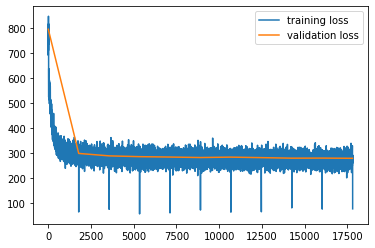

In [21]:
plt.plot(training_loss, label='training loss')
plt.plot(np.arange(len(validation_loss)) * len(mnist_train) / BATCH_SIZE, validation_loss, label='validation loss')
plt.legend()

In [0]:
reconstructed = autoencoder(mnist_test[6][0].to(device).unsqueeze(0))

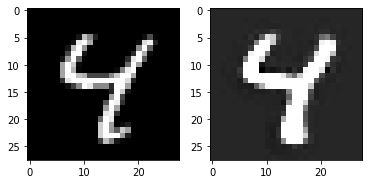

In [23]:
plt.subplot(121)
plt.imshow(mnist_test[6][0][0], cmap='gray')
plt.subplot(122)
plt.imshow(reconstructed[0][0].detach().cpu().numpy(), cmap='gray')

# Exercise 2: Transfer Learning

## Steps:

1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
3. Pretraining: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
4. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
5. From scratch: train the model on the 100 samples without reusing the decoder weights at all.
6. Show the accuracy of the four models on the MNIST test set in a table.


In [0]:
classifier = torch.nn.Linear(50, 10).to(device)

In [0]:
cross_entropy = torch.nn.CrossEntropyLoss()
adam = torch.optim.Adam(classifier.parameters(), lr=0.01)

In [0]:
training_subset = torch.utils.data.Subset(mnist_train, range(100))
subset_dataloader = torch.utils.data.DataLoader(training_subset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=4)

In [0]:
def classification_train(classifier, encoder, dataloader, criterion, optimizer, epoch, loss_history):
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        optimizer.zero_grad()
        # To latent space.
        codes = encoder(images).detach()
        # Classify from latent space.
        outputs = classifier(codes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

In [0]:
def classification_test(classifier, encoder, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        codes = encoder(images).detach()
        outputs = classifier(codes)
        loss += criterion(outputs, labels).item()
        # Compute average accuracy.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    mean_loss = loss / (i + 1)
    loss_history.append(mean_loss)  
    print('[%d, validation] loss: %.3f accuracy: %.3f' % (epoch + 1, mean_loss, 100 * correct / total))

In [0]:
training_loss = []
validation_loss = []

for epoch in range(80):
    classifier.eval()
    with torch.no_grad():
        classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)
    classifier.train()
    classification_train(classifier, autoencoder.encoder, subset_dataloader, cross_entropy, adam, epoch, training_loss)

classifier.eval()
with torch.no_grad():
    classification_test(classifier, autoencoder.encoder, val_dataloader, cross_entropy, epoch, validation_loss)

[1, validation] loss: 2.461 accuracy: 11.800
[1, 0] loss: 2.427
[1, 1] loss: 2.292
[1, 2] loss: 2.422
[1, 3] loss: 2.251
[2, validation] loss: 2.252 accuracy: 18.200
[2, 0] loss: 2.208
[2, 1] loss: 2.172
[2, 2] loss: 2.154
[2, 3] loss: 2.110
[3, validation] loss: 2.203 accuracy: 19.633
[3, 0] loss: 2.130
[3, 1] loss: 2.191
[3, 2] loss: 2.047
[3, 3] loss: 1.746
[4, validation] loss: 2.153 accuracy: 27.033
[4, 0] loss: 2.165
[4, 1] loss: 1.921
[4, 2] loss: 2.012
[4, 3] loss: 1.827
[5, validation] loss: 2.088 accuracy: 37.433
[5, 0] loss: 1.850
[5, 1] loss: 2.065
[5, 2] loss: 1.886
[5, 3] loss: 2.456
[6, validation] loss: 2.024 accuracy: 38.333
[6, 0] loss: 2.012
[6, 1] loss: 1.703
[6, 2] loss: 1.926
[6, 3] loss: 1.751
[7, validation] loss: 1.937 accuracy: 38.100
[7, 0] loss: 1.861
[7, 1] loss: 1.754
[7, 2] loss: 1.771
[7, 3] loss: 2.007
[8, validation] loss: 1.870 accuracy: 40.700
[8, 0] loss: 1.778
[8, 1] loss: 1.662
[8, 2] loss: 1.766
[8, 3] loss: 1.579
[9, validation] loss: 1.812 accu

In [0]:
plt.plot(training_loss, label='training loss')
plt.plot(np.arange(len(validation_loss)) * len(training_subset) / BATCH_SIZE, validation_loss, label='validation loss')
plt.legend();

In [0]:
test_dataloader = torch.utils.data.DataLoader(mnist_test,
                                             batch_size=1,
                                             num_workers=4)

In [0]:
classification_test(classifier, autoencoder.encoder, test_dataloader, cross_entropy, epoch, [])